In [1]:
import sys; sys.path.append('../')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from collections import OrderedDict
from loss import compare_activations, get_bre_loss, get_gradmask_loss
import copy
import itertools
import logging
import notebooks.auto_ipynb as auto_ipynb
import numpy as np
import pprint
import random
import time, os, sys
import torch
import torch.nn as nn
import utils.configuration as configuration
import utils.monitoring as monitoring
import models, models.CNN, models.ResNetSmall, models.UNet
import matplotlib.pyplot as plt
import datasets, datasets.MSDDataset
import glob

In [294]:
a= plt.cm

In [169]:
models_toplot.keys()

dict_keys(['Resnet Baseline', 'Unet Baseline', 'Resnet ActGrad', 'Unet ActGrad', 'Resnet ActDiff', 'Unet ActDiff', 'Resnet Gradmask', 'Unet Gradmask', 'Unet Masked'])

In [343]:
def render_img(text, idx, sample, sample_blur, modelz, exp_name, blur):

    fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15, 8), dpi=150, gridspec_kw={'hspace': 0.15, 'wspace': 0.01})
    fig.subplots_adjust(wspace=0.0)
    for a in ax:
        for aa in a:
            aa.axis('off')

    x, target, use_mask = sample
    img = x[0][0].cpu().numpy()
    #img = img / np.max(img)
    seg = x[1][0].cpu().numpy() 
    seg_blur = sample_blur[0][1][0]
    
    x_var = torch.autograd.Variable(x[0].unsqueeze(0),requires_grad=True)
    
    ax[0,0].set_title(str(idx) + "Image")
    ax[0,0].imshow(img, interpolation='none', cmap='Greys_r')
    ax[0,0].axis('off')    
    
    ax[0,1].set_title('Pathology + Mask (blur={})'.format(blur))
    ax[0,1].imshow((1-seg_blur).numpy()+(1-seg), cmap="Greys_r", interpolation='none')
    ax[0,1].axis('on')
    ax[0,1].get_xaxis().set_ticks([])
    ax[0,1].get_yaxis().set_ticks([])

    my_cmap = plt.cm.jet
    my_cmap.set_under('k', alpha=0)
    
    name = "UNet Masked"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[2,4].set_title(name)
    ax[2,4].imshow(img, interpolation='none', cmap='Greys_r')
    ax[2,4].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[2,4].axis('off')  
    ax[1,4].set_title("Unet Masked Recon")
    ax[1,4].imshow(x_prime.detach().numpy()[0][0], interpolation='none', cmap='Greys_r')
    ax[1,4].axis('off')  
    
    name = "UNet Baseline"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[2,0].set_title(name)
    ax[2,0].imshow(img, interpolation='none', cmap='Greys_r')
    ax[2,0].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[2,0].axis('off')
    ax[0,4].set_title("Unet Baseline Recon")
    ax[0,4].imshow(x_prime.detach().numpy()[0][0], interpolation='none', cmap='Greys_r')
    ax[0,4].axis('off')  
    
    
    name = "Resnet Baseline"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[1,0].set_title(name)
    ax[1,0].imshow(img, interpolation='none', cmap='Greys_r')
    ax[1,0].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[1,0].axis('off')  
    
    name = "Resnet ActDiff"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[1,1].set_title(name)
    ax[1,1].imshow(img, interpolation='none', cmap='Greys_r')
    ax[1,1].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[1,1].axis('off')
    
    name = "UNet ActDiff"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[2,1].set_title(name)
    ax[2,1].imshow(img, interpolation='none', cmap='Greys_r')
    ax[2,1].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[2,1].axis('off')
    
    name = "Resnet Gradmask"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[1,2].set_title(name)
    ax[1,2].imshow(img, interpolation='none', cmap='Greys_r')
    ax[1,2].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[1,2].axis('off')
    
    name = "UNet Gradmask"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[2,2].set_title(name)
    ax[2,2].imshow(img, interpolation='none', cmap='Greys_r')
    ax[2,2].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[2,2].axis('off')
    
    name = "Resnet ActGrad"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[1,3].set_title(name)
    ax[1,3].imshow(img, interpolation='none', cmap='Greys_r')
    ax[1,3].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[1,3].axis('off')
    
    name = "UNet ActGrad"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[2,3].set_title(name)
    ax[2,3].imshow(img, interpolation='none', cmap='Greys_r')
    ax[2,3].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[2,3].axis('off')
    
    plt.tight_layout()
    plt.show()

In [344]:
# idx = 2
# print(toplot)
# blur = 8
# d.blur =blur
# sample_blur = d[idx]
# d.blur =0
# sample = d[idx]
# print(sample[1])
# a = render_img("aaa", "", sample,sample_blur, models_toplot, "a", blur)
# plt.show()

In [345]:
# for i in range(10):
#     idx = i
#     print(toplot)
#     blur = 16
#     d.blur =blur
#     sample_blur = d[idx]
#     d.blur =0
#     sample = d[idx]
#     print(sample[1])
#     a = render_img("aaa", "", sample,sample_blur, models_toplot, "a", blur)
#     plt.show()

In [5]:
glob.glob("/network/tmp1/vivianoj/checkpoints/*resnet*/best_model_1234_1.0.pth.tar")

['/network/tmp1/vivianoj/checkpoints/pancreasmsd_resnet_actgrad/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/cardiacmsd_resnet/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/synth_resnet_gradmask/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/pancreasmsd_resnet_actdiff/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/cardiacmsd_resnet_actgrad/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/livermsd_resnet/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/cardiacmsd_resnet_actdiff/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/cardiacmsd_resnet_clfmasked/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/synth_resnet_clfmasked/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/synth_resnet_actdiff/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/synth_resnet_actgrad/best_model_1234_1.0.pth.tar',
 '/netwo

In [127]:
glob.glob("/network/tmp1/vivianoj/checkpoints/*unet*/best_model_1234_1.0.pth.tar")

['/network/tmp1/vivianoj/checkpoints/pancreasmsd_unet_gradmask/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/synth_unet_actdiff/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/synth_unet_actgrad/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/cardiacmsd_unet_reconmasked/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/livermsd_unet_actgrad/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/synth_unet_reconmasked/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/cardiacmsd_unet/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/livermsd_unet_actdiff/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/synth_unet_gradmask/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/livermsd_unet_gradmask/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/livermsd_unet_clfmasked/best_model_1234_1.0.pth.tar',
 '/network/tmp1/vivia

In [355]:
toplot = "cardiacmsd"

In [356]:
if toplot == "cardiacmsd":
    d = datasets.MSDDataset.HeartMSDDataset(mode='test', nsamples=10, blur=4)
elif toplot == "livermsd":
    d = datasets.MSDDataset.LiverMSDDataset(mode='test', nsamples=1000, blur=4)
elif toplot == "pancreasmsd":
    d = datasets.MSDDataset.PancreasMSDDataset(mode='test', nsamples=1000, blur=4)

Full dataset contains: Counter({True: 1351, False: 920})
mode=test
Loading 8 files:['la_017.nii.gz', 'la_014.nii.gz', 'la_024.nii.gz', 'la_019.nii.gz', 'la_007.nii.gz', 'la_003.nii.gz', 'la_023.nii.gz', 'la_020.nii.gz']
Loaded images contain:Counter({True: 540, False: 400})
This dataloader contains: Counter({True: 5, False: 5})


In [335]:
# a= torch.load("/network/tmp1/vivianoj/checkpoints/{}_cnn{}/best_model.pth.tar".format(toplot, activdif), map_location='cpu')
# cnn = models.UNet.UNet(img_size=100, nc=64, mode='cnn')
# cnn.load_state_dict(a.state_dict())

In [348]:
models_toplot = {}

for name, suf in [("Baseline",""),
                  ("ActGrad","_actgrad"),
                  ("ActDiff","_actdiff"),
                  ("Gradmask","_gradmask")]:
    
    a= torch.load("/network/tmp1/vivianoj/checkpoints/{}_resnet{}/best_model_1234_1.0.pth.tar".format(toplot, suf), map_location='cpu')
    resnet = models.ResNetSmall.ResNetSmall(base_size=4608, img_size=100)
    resnet.load_state_dict(a.state_dict())

    a= torch.load("/network/tmp1/vivianoj/checkpoints/{}_unet{}/best_model_1234_1.0.pth.tar".format(toplot, suf), map_location='cpu')
    unet = models.UNet.UNet(img_size=100, nc=64, mode='unet', normrecon=False)
    unet.load_state_dict(a.state_dict())

#     a= torch.load("/network/tmp1/vivianoj/checkpoints/{}_ae{}/best_model_1234_1.0.pth.tar".format(toplot, suf), map_location='cpu')
#     unet = models.UNet.UNet(img_size=100, nc=64, mode='ae', normrecon=False)
#     unet.load_state_dict(a.state_dict())
    
    models_toplot["Resnet " + name] = resnet
    models_toplot["UNet " + name] = unet
    
a= torch.load("/network/tmp1/vivianoj/checkpoints/{}_unet_reconmasked/best_model_1234_1.0.pth.tar".format(toplot, suf), map_location='cpu')
unet = models.UNet.UNet(img_size=100, nc=64, mode='unet', normrecon=False)
unet.load_state_dict(a.state_dict())
models_toplot["UNet Masked"] = unet
    

In [349]:
models_toplot.keys()

dict_keys(['Resnet Baseline', 'UNet Baseline', 'Resnet ActGrad', 'UNet ActGrad', 'Resnet ActDiff', 'UNet ActDiff', 'Resnet Gradmask', 'UNet Gradmask', 'UNet Masked'])

In [350]:
# a= torch.load("/network/tmp1/vivianoj/checkpoints/{}_unet{}/best_model.pth.tar".format(toplot, activdif), map_location='cpu')
# unet = models.UNet.UNet(img_size=100, nc=64, mode='unet', normrecon=False)
# weights = a.state_dict()
# unet.load_state_dict(weights)

In [358]:
idx = 466
print(toplot)
blur = 16
d.blur =blur
sample_blur = d[idx]
d.blur =0
sample = d[idx]
print(sample[1])
a = render_img("aaa", "", sample,sample_blur, models_toplot, "a", blur)
plt.show()

cardiacmsd


IndexError: index 466 is out of bounds for axis 0 with size 10

cardiacmsd
1
0


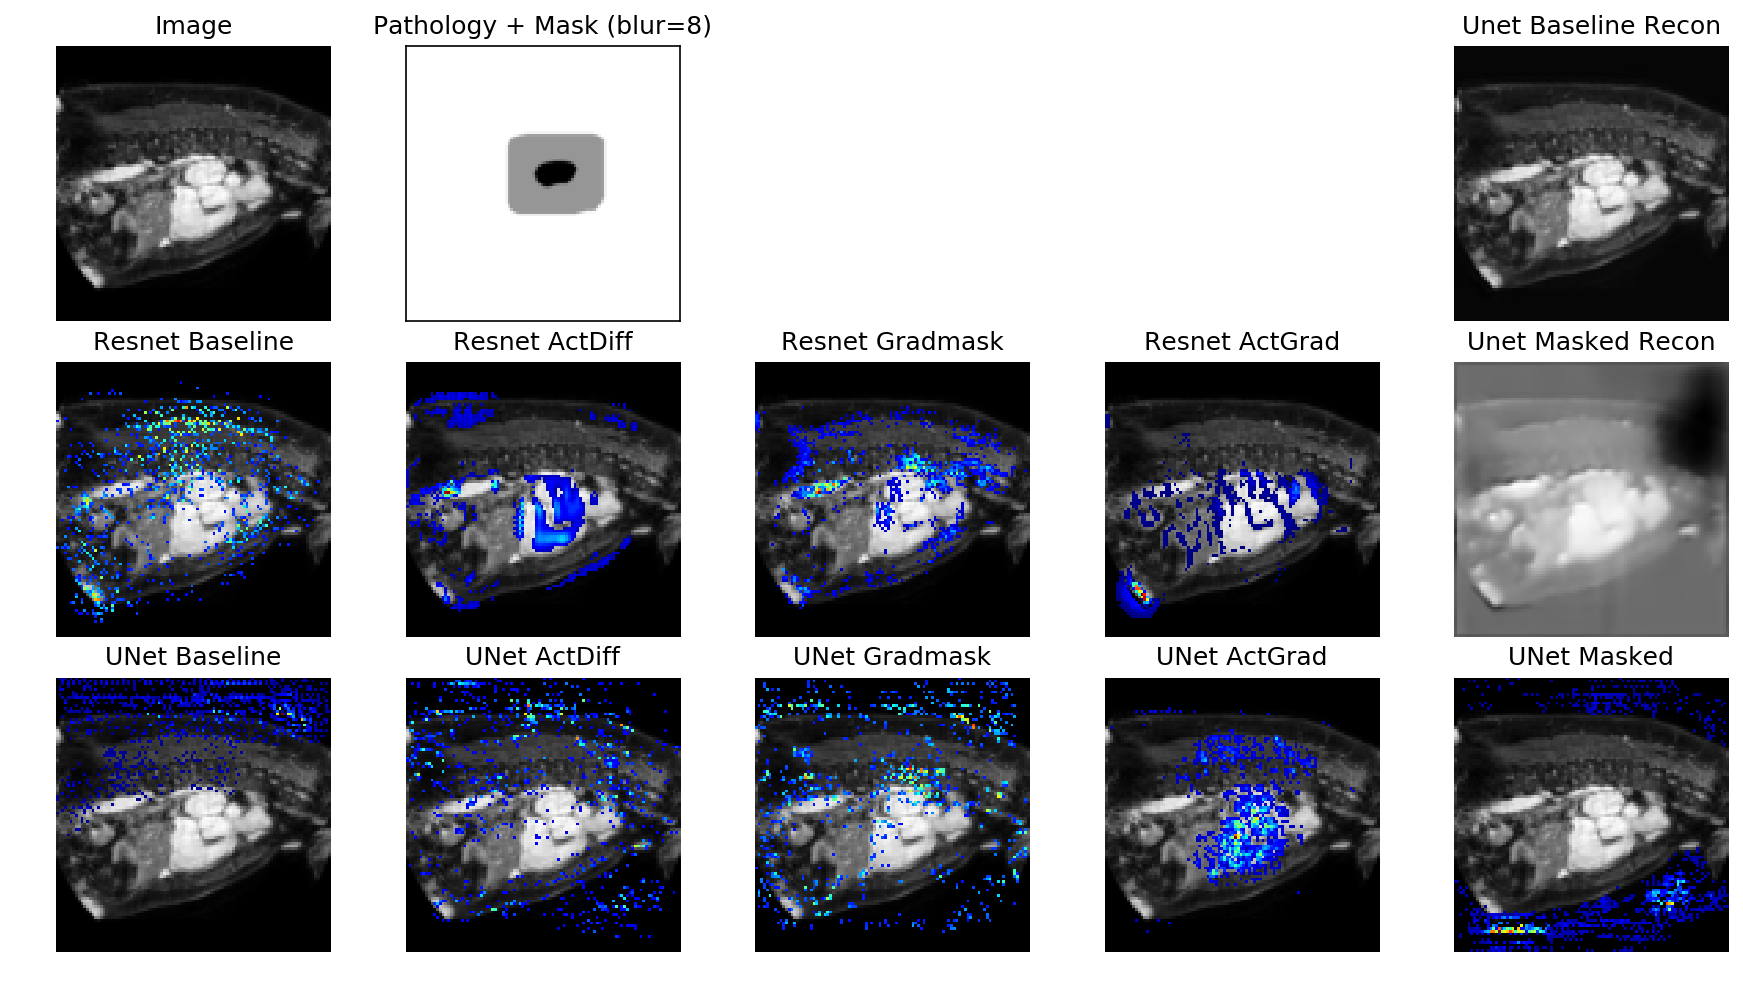

cardiacmsd
1
1


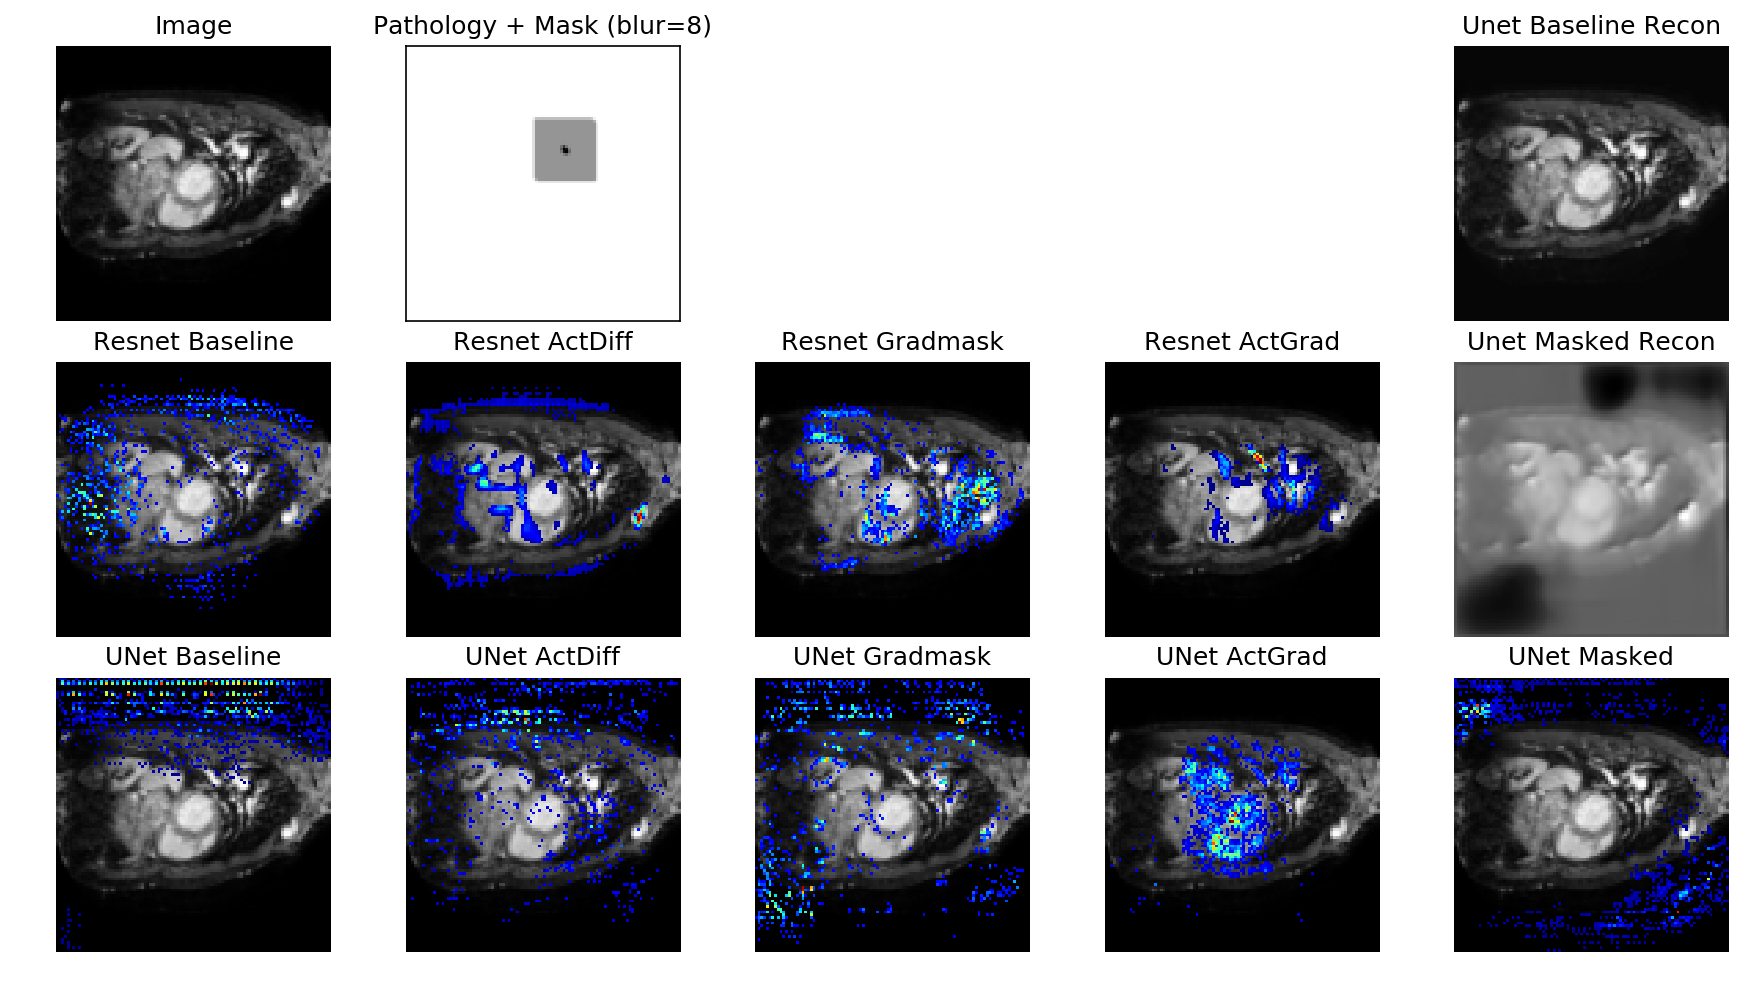

cardiacmsd
1
2


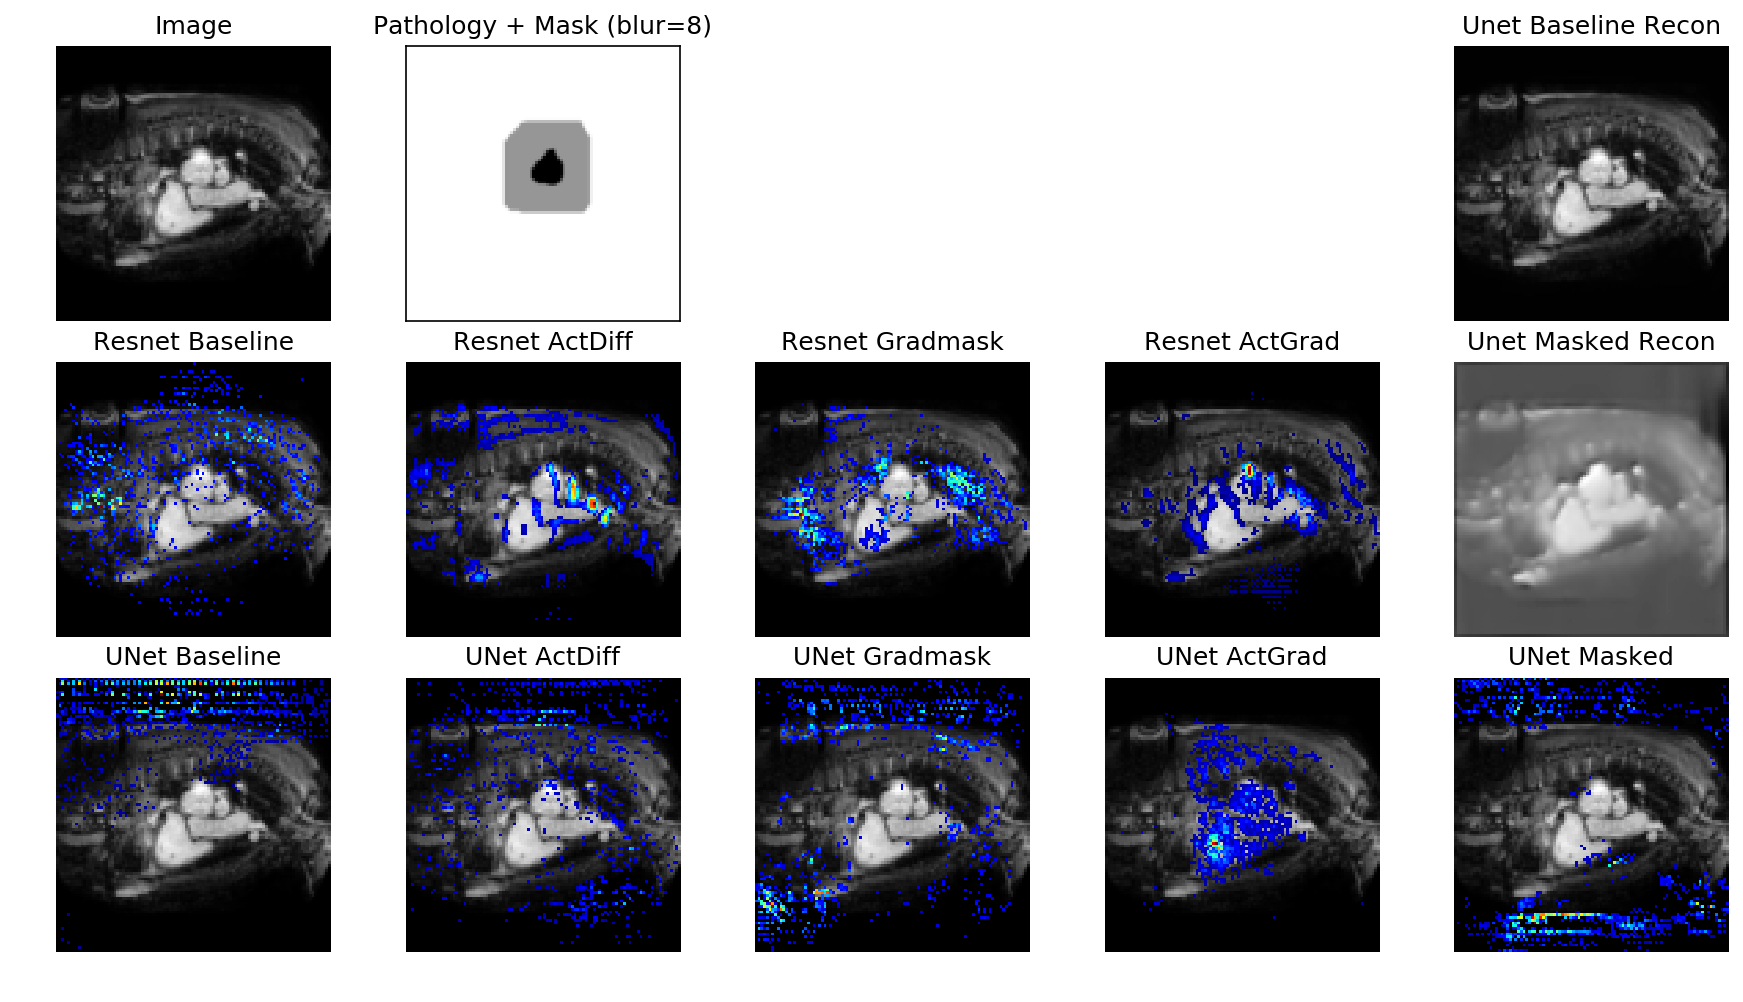

cardiacmsd
1
3


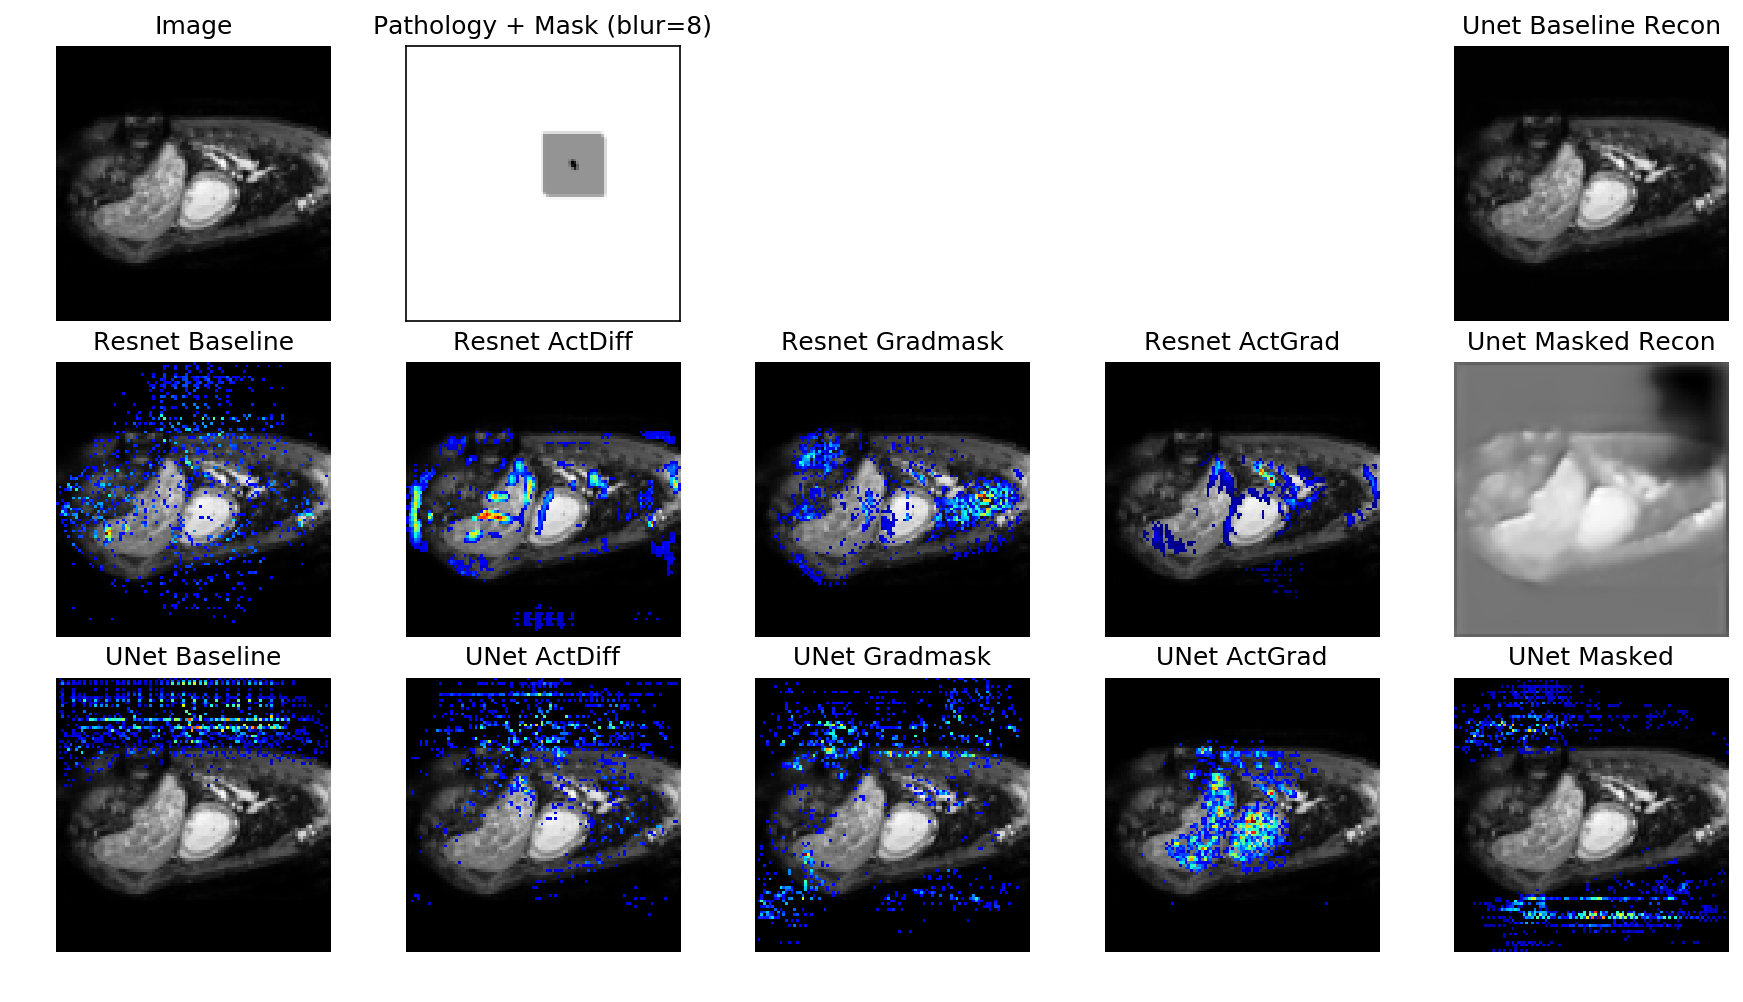

cardiacmsd
1
4


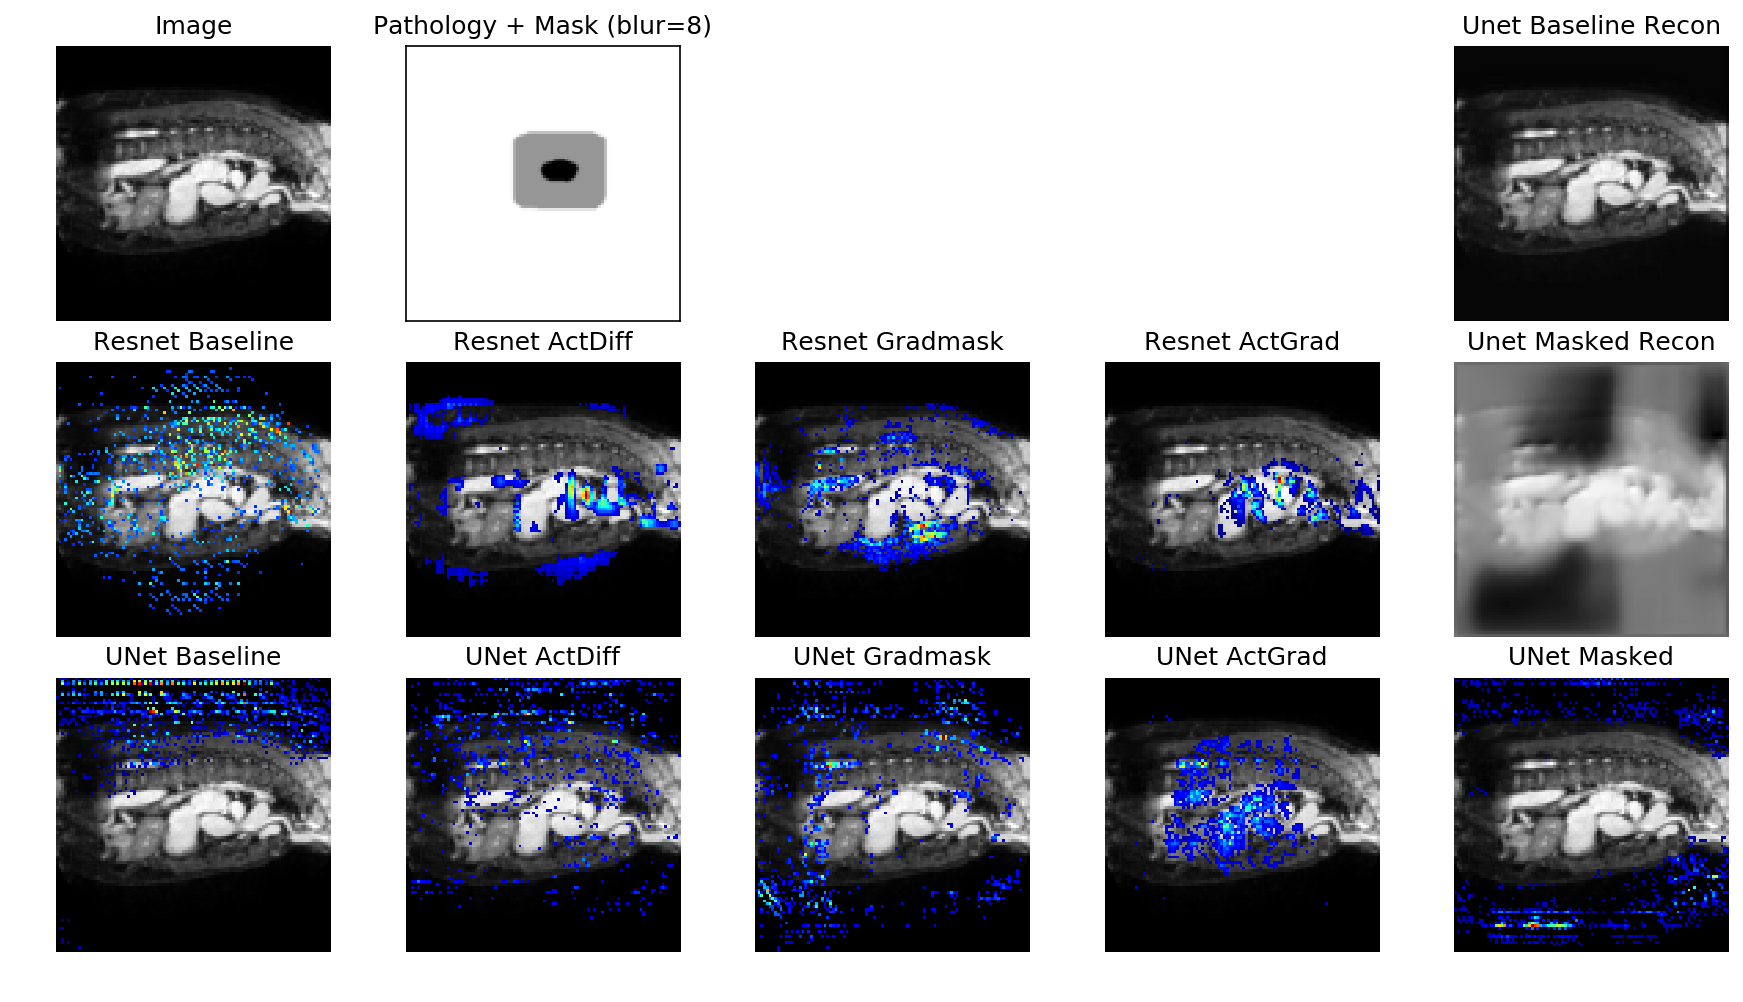

cardiacmsd
0
5


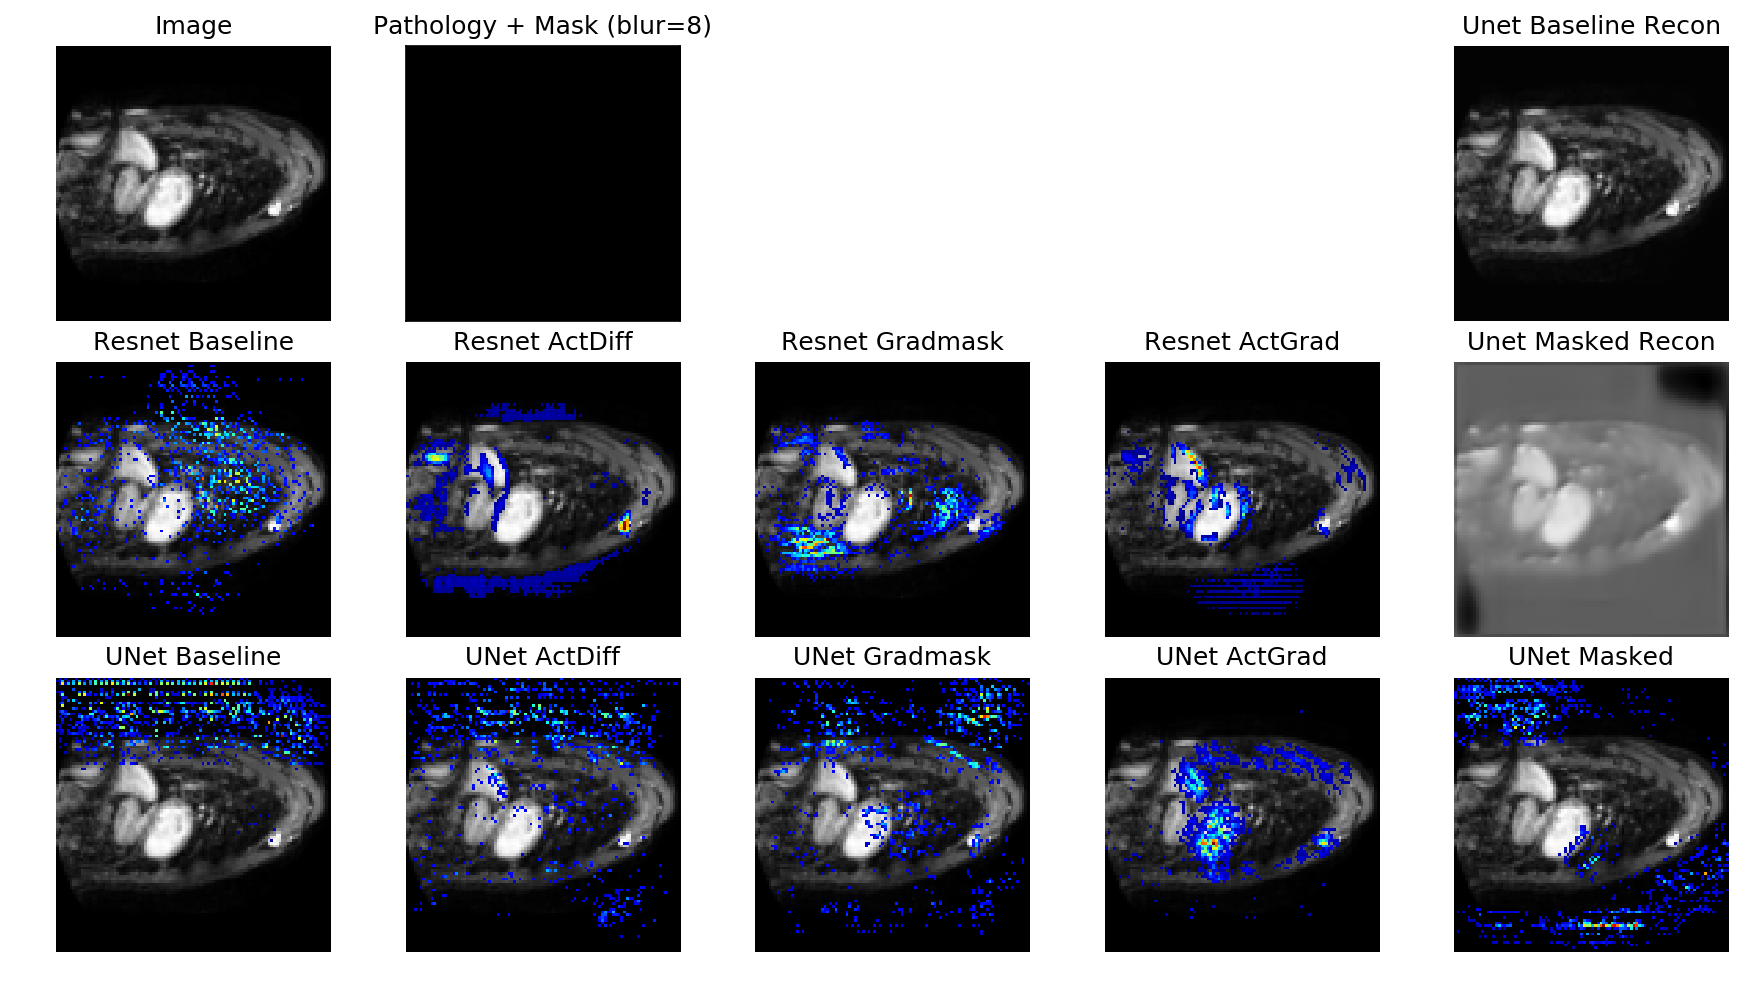

cardiacmsd
0
6


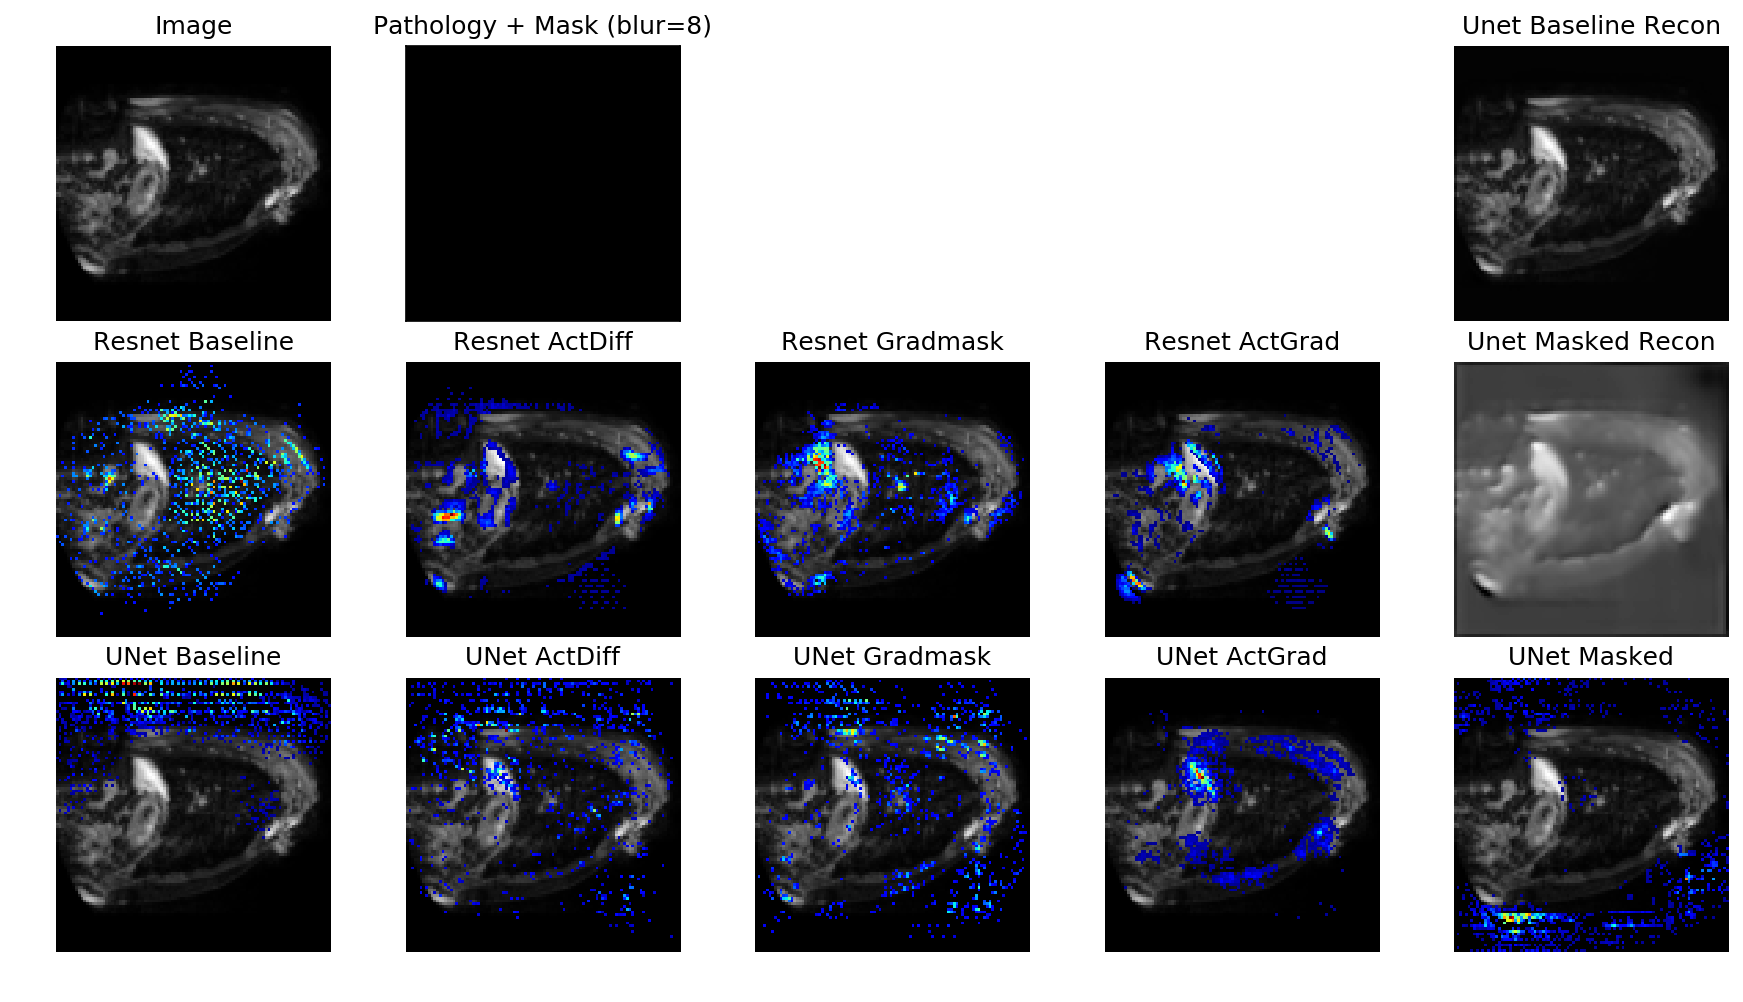

cardiacmsd
0
7


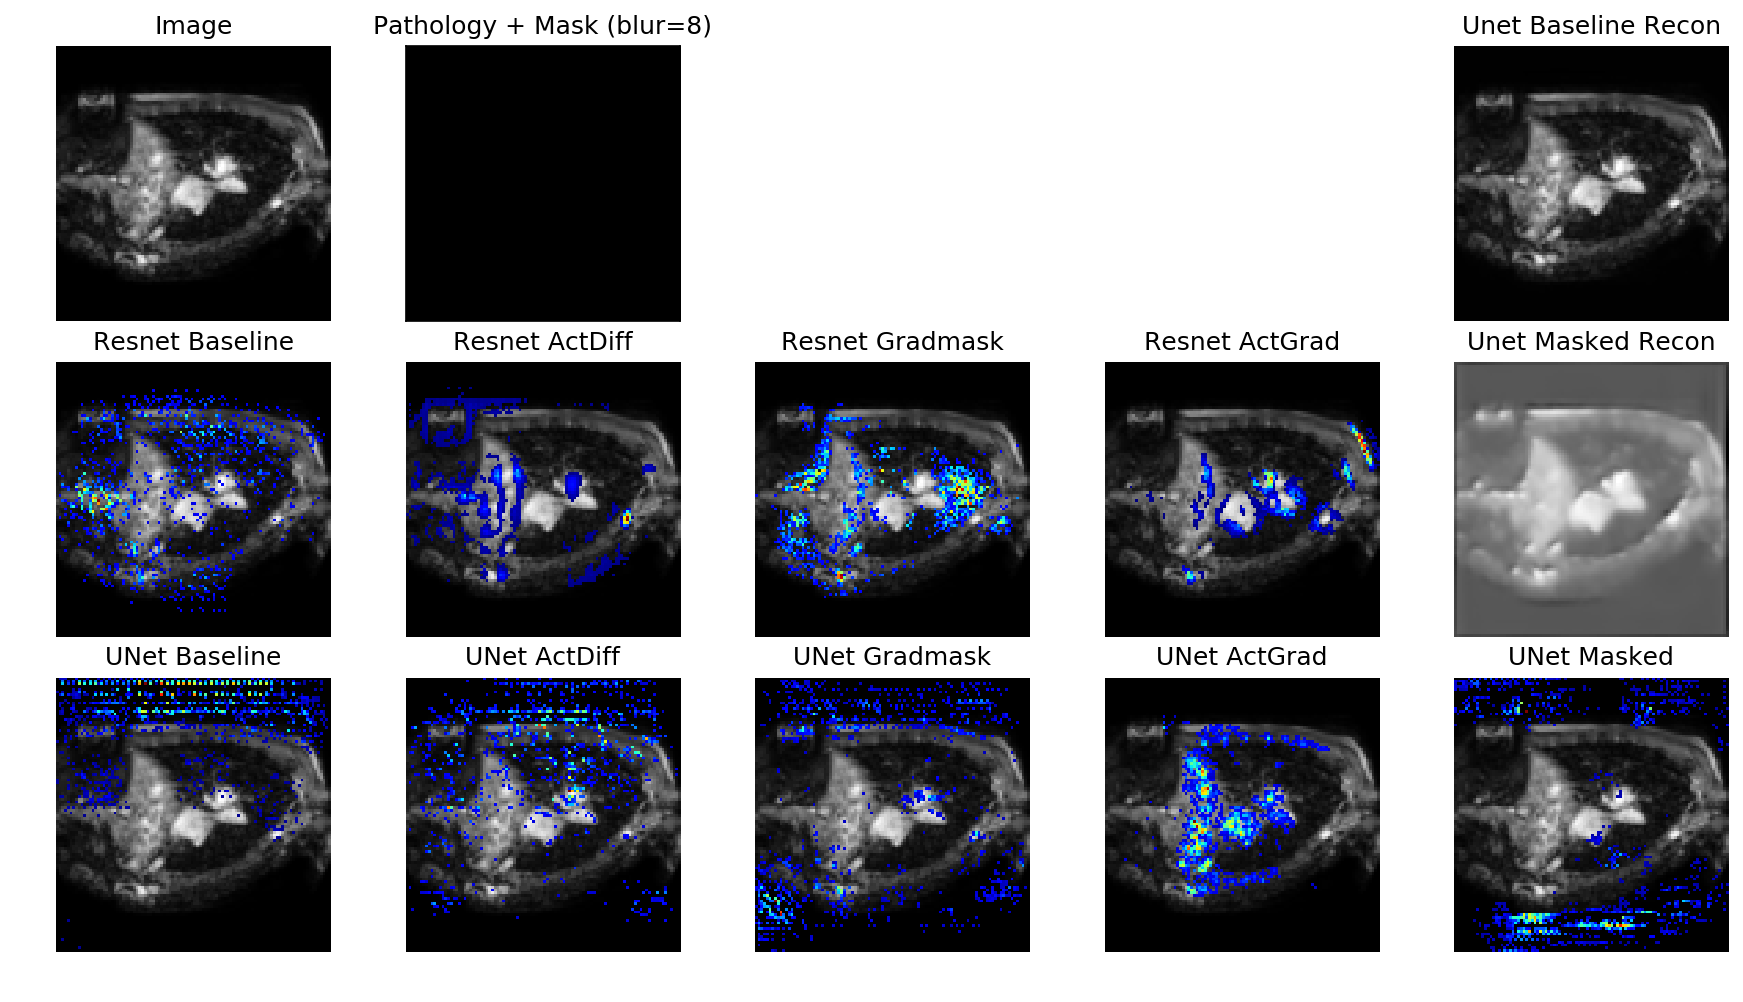

cardiacmsd
0
8


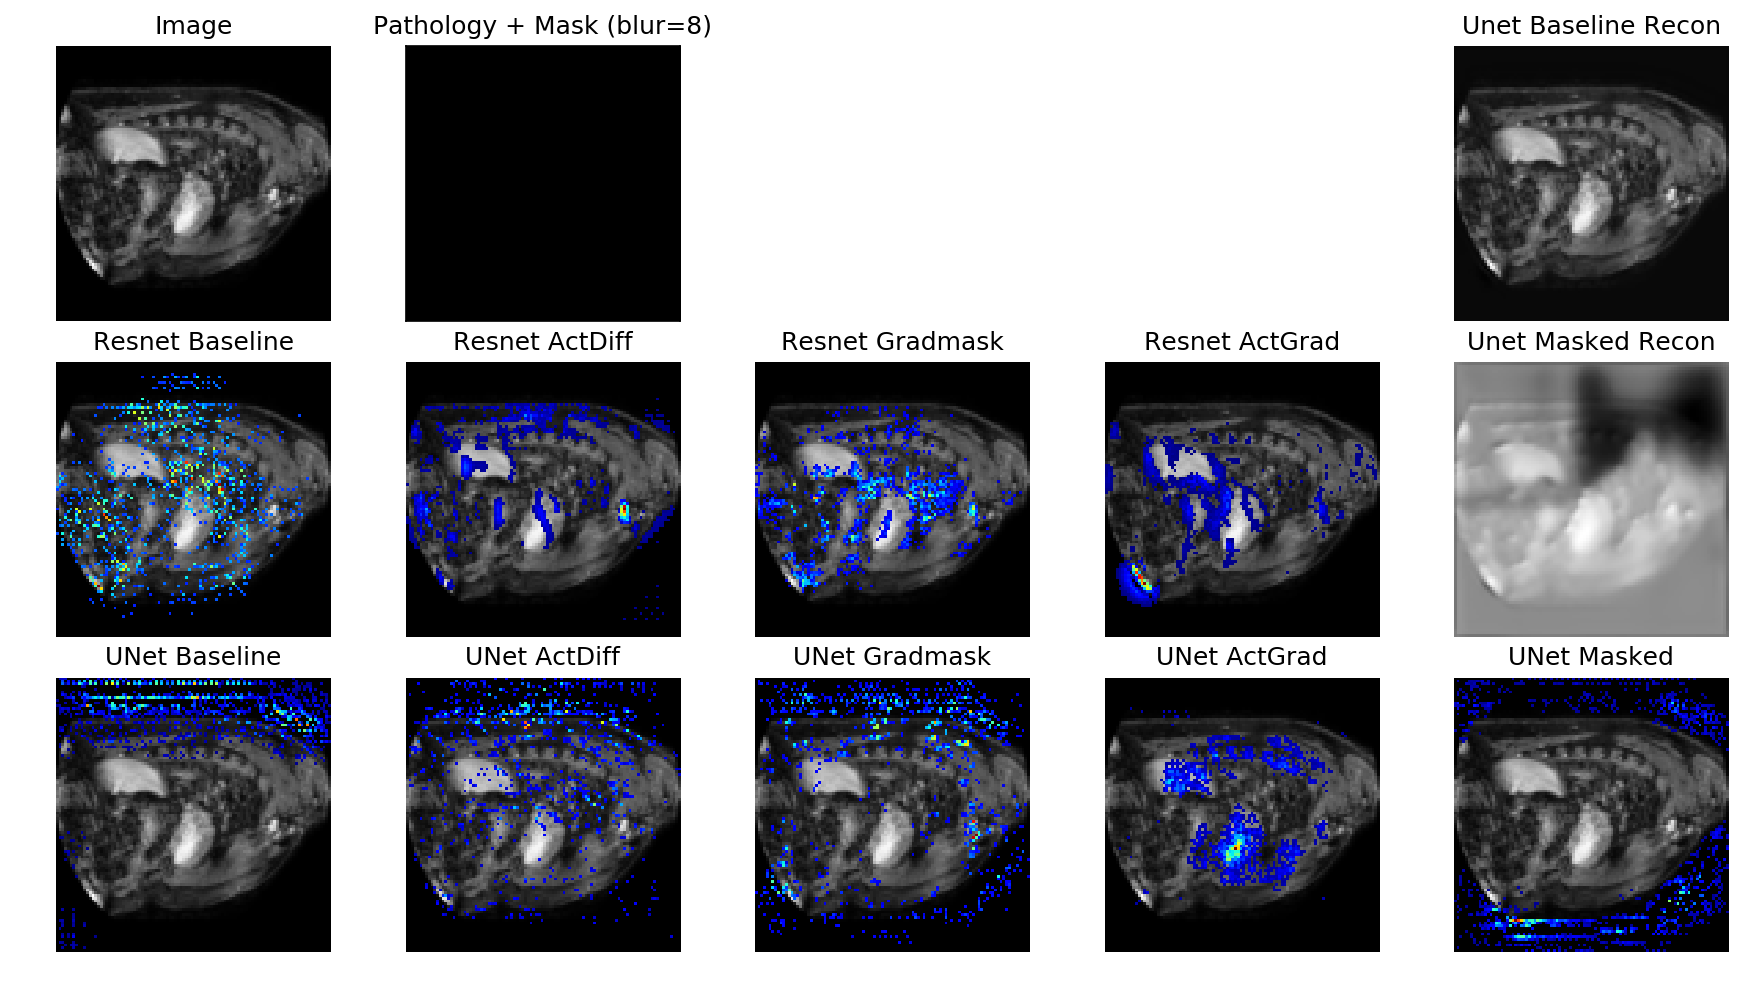

cardiacmsd
0
9


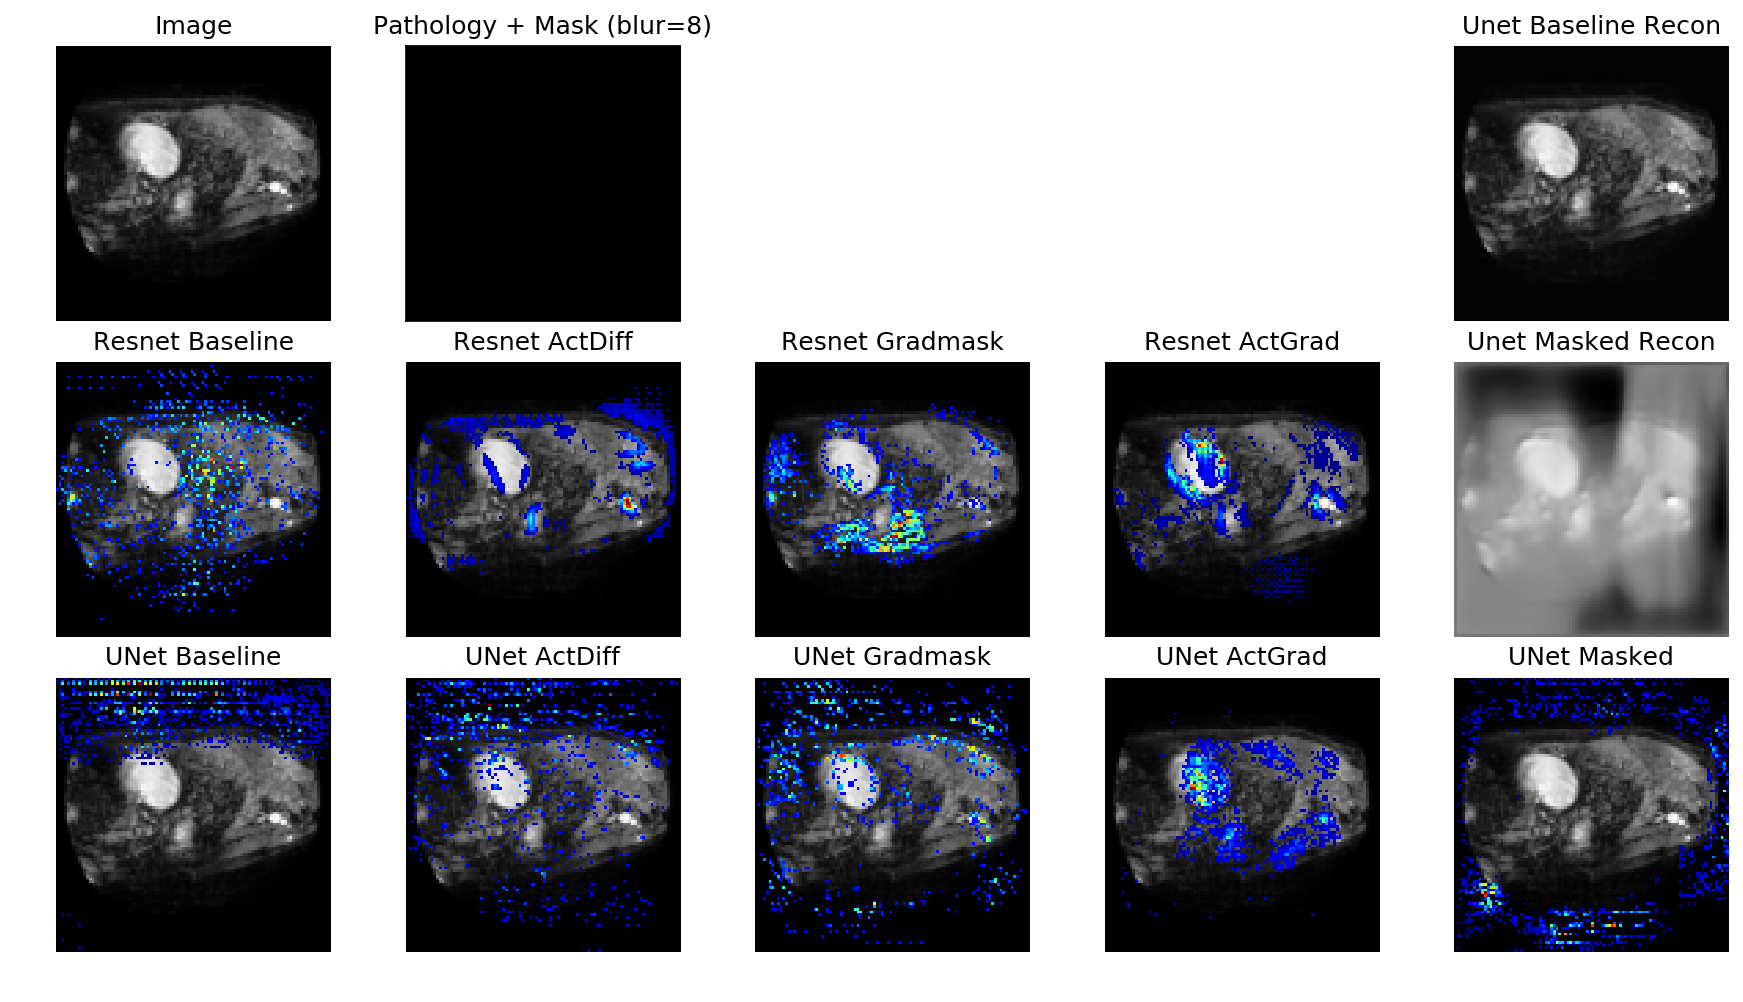

In [359]:
for i in range(10):
    idx = i
    print(toplot)
    blur = 8
    d.blur =blur
    sample_blur = d[idx]
    d.blur =0
    sample = d[idx]
    print(sample[1])
    print(idx)
    a = render_img("aaa", "", sample,sample_blur, models_toplot, "a", blur)
    plt.show()

In [84]:
(a>np.percentile(a,90)).shape

(100, 100)

In [93]:
a*(a>np.percentile(a,90))

array([[-0., -0., -0., ..., -0., -0., -0.],
       [ 0.,  0., -0., ...,  0.,  0., -0.],
       [ 0.,  0., -0., ..., -0.,  0., -0.],
       ...,
       [ 0.,  0., -0., ...,  0.,  0., -0.],
       [ 0., -0., -0., ..., -0.,  0., -0.],
       [ 0.,  0.,  0., ..., -0.,  0., -0.]], dtype=float32)

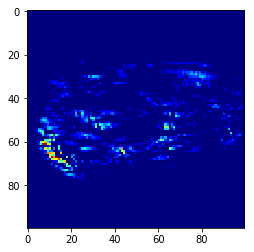

In [95]:
plt.imshow(a*(a>np.percentile(a,90)), cmap="jet", interpolation='none');

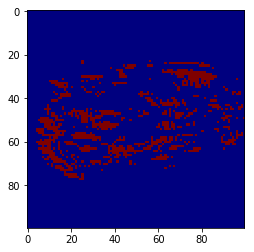

In [79]:
plt.imshow(a>np.percentile(a,90), cmap="jet", interpolation='none')

In [475]:
name, resnet, unet = models_toplot[2]
print(name)
gradz = []
for s in d:
    x,_,_ = s
    x = torch.tensor(x[0])
    x_var = torch.autograd.Variable(x.unsqueeze(0),requires_grad=True)
    y_prime, x_prime = resnet(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                         "contrast").detach().cpu().numpy()[0][0]
    gradz.append(gradmask)

Gradmask


/network/home/cohenjos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


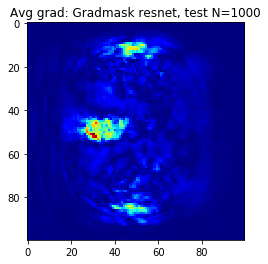

In [479]:
toagg = np.asarray(gradz)
toagg = toagg[d.labels==True]
plt.imshow(np.abs(toagg.mean(0)), cmap="jet", interpolation='none')
plt.title("Avg grad: " + name + " resnet, test N=" + str(len(gradz)));

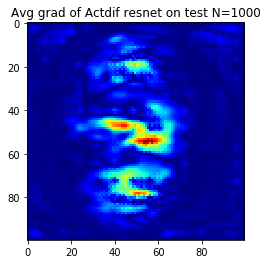

In [472]:
toagg = np.asarray(gradz)
toagg = toagg[d.labels==True]
plt.imshow(np.abs(toagg.mean(0)), cmap="jet", interpolation='none')
plt.title("Avg grad of " + name + " resnet on test N=" + str(len(gradz)));

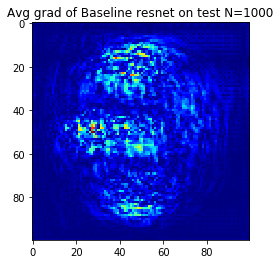

In [474]:
toagg = np.asarray(gradz)
toagg = toagg[d.labels==True]
plt.imshow(np.abs(toagg.mean(0)), cmap="jet", interpolation='none')
plt.title("Avg grad of " + name + " resnet on test N=" + str(len(gradz)));

200


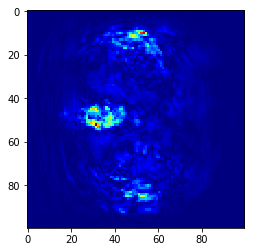

In [433]:
print(len(gradz))
toagg = np.asarray(gradz)
toagg = toagg[d.labels==True]
plt.imshow(np.abs(toagg.mean(0)), cmap="jet", interpolation='none')

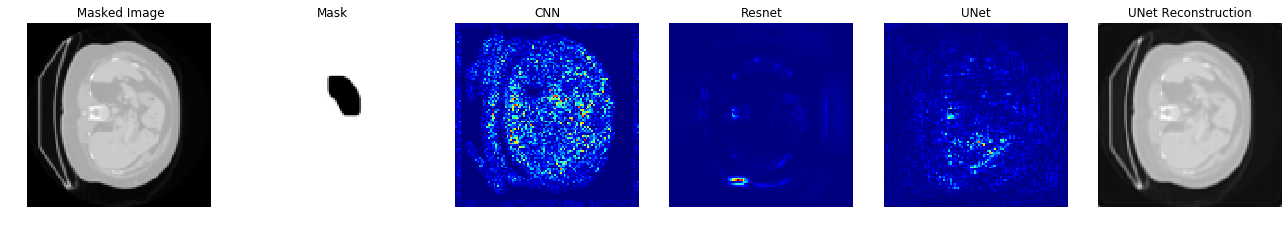

In [109]:
sample = d[1]
render_img("aaa", "", sample, cnn, resnet, unet, "a")